# 🌎 Análisis de Sentimiento Multilingüe para Comentarios Turísticos

## Pipeline End-to-End Profesional

**Objetivo Principal:** Enriquecer el dataset de comentarios turísticos con métricas de sentimiento multilingüe, análisis por aspectos (ABSA) y emociones.

### Estructura del Notebook:

| Fase | Descripción |
|------|-------------|
| **0** | Configuración y Contexto |
| **1** | Carga y Verificación del Dataset |
| **2** | Limpieza Básica y Tipificación |
| **3** | EDA General (No Textual) |
| **4** | EDA de Texto Multilingüe |
| **5** | Diseño del Esquema de Sentimiento |
| **6** | Generación de Sentimientos (Transformer Multilingüe) |
| **7** | Modelo Baseline (TF-IDF + Clasificador) |
| **8** | ABSA: Análisis de Sentimiento por Aspectos |
| **9** | Modelo de Emociones |
| **10** | Evaluación y Comparación de Modelos |
| **11** | Explicabilidad Avanzada |
| **12** | Integración y Exportación del Dataset Enriquecido |
| **13** | Documentación y Metadatos JSON |

---

**Archivo de entrada:** `p3-sentimiento_comentariosmuestra.xlsx`

**Columnas esperadas (15):**
- `ID`, `Fecha_publicacion`, `Titulo`, `Idioma_comentario`, `Comentario`
- `Rating_usuario`, `Fecha_viaje`, `Tipo_trip`, `Cantidad_contribuciones_usuario`
- `Lugar_numero_reviews`, `Lugar_rating`, `DEPARTAMENTO`, `AÑO`, `MES`, `DIA`

---
# 📦 FASE 0: Configuración y Contexto
---

In [22]:
# ============================================================================
# FASE 0.1: IMPORTACIÓN DE LIBRERÍAS
# ============================================================================

# --- Manipulación de datos ---
import pandas as pd
import numpy as np

# --- Visualización ---
import matplotlib.pyplot as plt
import seaborn as sns
try:
    import plotly.express as px
    import plotly.graph_objects as go
    PLOTLY_AVAILABLE = True
except ImportError:
    PLOTLY_AVAILABLE = False
    print("⚠️ Plotly no disponible, usando solo matplotlib")

# --- Texto y utilidades ---
import re
import string
from collections import Counter, defaultdict
try:
    from langdetect import detect, LangDetectException
    LANGDETECT_AVAILABLE = True
except ImportError:
    LANGDETECT_AVAILABLE = False
    print("⚠️ langdetect no disponible")

try:
    from tqdm.auto import tqdm
    tqdm.pandas()
except ImportError:
    tqdm = lambda x, **kwargs: x
    print("⚠️ tqdm no disponible")

# --- Modelado de sentimiento ---
try:
    from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
    import torch
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True
    TRANSFORMERS_AVAILABLE = True
except ImportError:
    TRANSFORMERS_AVAILABLE = False
    print("⚠️ transformers/torch no disponible")

# --- Machine Learning clásico ---
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, f1_score)

# --- Otros ---
import json
import os
import warnings
from datetime import datetime, timedelta
import time
from typing import Dict, List, Tuple, Optional, Any

warnings.filterwarnings('ignore')
print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


In [23]:
# ============================================================================
# FASE 0.2: CONFIGURACIÓN GLOBAL
# ============================================================================

# --- Rutas de archivos ---
DATA_PATH = "./p3-sentimiento_comentarios_transformed.xlsx"

# Rutas de salida
OUTPUT_XLSX = "./p3-sentimiento_comentarios_with_sentiment.xlsx"
OUTPUT_PARQUET = "./p3-sentimiento_comentarios_with_sentiment.parquet"
OUTPUT_CSV = "./p3-sentimiento_comentarios_with_sentiment.csv"
METADATA_JSON = "./sentiment_model_metadata.json"

# Carpetas de salida
FIGURES_DIR = "./figures"
REPORTS_DIR = "./reports"
MODELS_DIR = "./models"

# Crear carpetas
for directory in [FIGURES_DIR, REPORTS_DIR, MODELS_DIR]:
    os.makedirs(directory, exist_ok=True)
    os.makedirs(f"{directory}/eda_general", exist_ok=True)
    os.makedirs(f"{directory}/eda_text", exist_ok=True)

# --- Semilla para reproducibilidad ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
if TRANSFORMERS_AVAILABLE:
    torch.manual_seed(RANDOM_STATE)

# --- Configuración de Pandas ---
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# --- Configuración de Matplotlib/Seaborn ---
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
sns.set_style('whitegrid')
sns.set_palette('husl')

# --- Columnas esperadas del dataset ---
EXPECTED_COLUMNS = [
    'ID', 'Fecha_publicacion', 'Titulo', 'Idioma_comentario', 'Comentario',
    'Rating_usuario', 'Fecha_viaje', 'Tipo_trip', 'Cantidad_contribuciones_usuario',
    'Lugar_numero_reviews', 'Lugar_rating', 'DEPARTAMENTO', 'AÑO', 'MES', 'DIA'
]

# --- Configuración de modelos ---
MODEL_CONFIG = {
    'sentiment_multilingual': 'clapAI/roberta-large-multilingual-sentiment',
    'sentiment_alternative': 'nlptown/bert-base-multilingual-uncased-sentiment',
    'batch_size_gpu': 64,
    'batch_size_cpu': 16,
    'max_length': 256
}

# --- Verificar dispositivo ---
if TRANSFORMERS_AVAILABLE:
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    DEVICE_ID = 0 if torch.cuda.is_available() else -1
else:
    DEVICE = 'cpu'
    DEVICE_ID = -1

print("="*60)
print("CONFIGURACIÓN GLOBAL ESTABLECIDA")
print("="*60)
print(f"📁 Archivo de entrada: {DATA_PATH}")
print(f"📁 Salida XLSX: {OUTPUT_XLSX}")
print(f"🎲 Semilla aleatoria: {RANDOM_STATE}")
print(f"🖥️  Dispositivo: {DEVICE}")
if TRANSFORMERS_AVAILABLE and torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
print(f"🧠 Modelo principal: {MODEL_CONFIG['sentiment_multilingual']}")
print("="*60)

CONFIGURACIÓN GLOBAL ESTABLECIDA
📁 Archivo de entrada: ./p3-sentimiento_comentarios_transformed.xlsx
📁 Salida XLSX: ./p3-sentimiento_comentarios_with_sentiment.xlsx
🎲 Semilla aleatoria: 42
🖥️  Dispositivo: cuda
🎮 GPU: NVIDIA GeForce RTX 4070 Ti SUPER
🧠 Modelo principal: clapAI/roberta-large-multilingual-sentiment


---
# 📥 FASE 1: Carga y Verificación del Dataset
---

In [24]:
# ============================================================================
# FASE 1.1: CARGA DEL DATASET
# ============================================================================

print("⏳ Cargando dataset...")
t_start = time.time()

df_raw = pd.read_excel(DATA_PATH)

t_elapsed = time.time() - t_start
print(f"✓ Dataset cargado en {t_elapsed:.2f} segundos")
print(f"📊 Dimensiones: {df_raw.shape[0]:,} filas × {df_raw.shape[1]} columnas")

⏳ Cargando dataset...
✓ Dataset cargado en 34.42 segundos
📊 Dimensiones: 196,313 filas × 15 columnas


In [25]:
# ============================================================================
# FASE 1.2: VERIFICACIÓN DE ESTRUCTURA
# ============================================================================

print("="*60)
print("VERIFICACIÓN DE COLUMNAS")
print("="*60)

actual_columns = df_raw.columns.tolist()

print("\n📋 Columnas ESPERADAS (15):")
for i, col in enumerate(EXPECTED_COLUMNS, 1):
    status = "✓" if col in actual_columns else "✗"
    print(f"   {i:2d}. {status} {col}")

print("\n📋 Columnas REALES encontradas:")
for i, col in enumerate(actual_columns, 1):
    status = "✓" if col in EXPECTED_COLUMNS else "⚠️ (extra)"
    print(f"   {i:2d}. {status} {col}")

# Verificar coincidencia
missing = set(EXPECTED_COLUMNS) - set(actual_columns)
extra = set(actual_columns) - set(EXPECTED_COLUMNS)

print(f"\n📊 Resumen:")
print(f"   - Columnas esperadas: {len(EXPECTED_COLUMNS)}")
print(f"   - Columnas encontradas: {len(actual_columns)}")
print(f"   - Columnas faltantes: {len(missing)} {list(missing) if missing else ''}")
print(f"   - Columnas extra: {len(extra)} {list(extra) if extra else ''}")

VERIFICACIÓN DE COLUMNAS

📋 Columnas ESPERADAS (15):
    1. ✓ ID
    2. ✓ Fecha_publicacion
    3. ✓ Titulo
    4. ✓ Idioma_comentario
    5. ✓ Comentario
    6. ✓ Rating_usuario
    7. ✓ Fecha_viaje
    8. ✓ Tipo_trip
    9. ✓ Cantidad_contribuciones_usuario
   10. ✓ Lugar_numero_reviews
   11. ✓ Lugar_rating
   12. ✓ DEPARTAMENTO
   13. ✓ AÑO
   14. ✓ MES
   15. ✓ DIA

📋 Columnas REALES encontradas:
    1. ✓ ID
    2. ✓ Fecha_publicacion
    3. ✓ Titulo
    4. ✓ Idioma_comentario
    5. ✓ Comentario
    6. ✓ Rating_usuario
    7. ✓ Fecha_viaje
    8. ✓ Tipo_trip
    9. ✓ Cantidad_contribuciones_usuario
   10. ✓ Lugar_numero_reviews
   11. ✓ Lugar_rating
   12. ✓ DEPARTAMENTO
   13. ✓ AÑO
   14. ✓ MES
   15. ✓ DIA

📊 Resumen:
   - Columnas esperadas: 15
   - Columnas encontradas: 15
   - Columnas faltantes: 0 
   - Columnas extra: 0 


In [26]:
# ============================================================================
# FASE 1.3: INFORMACIÓN BÁSICA DEL DATASET
# ============================================================================

print("="*60)
print("INFORMACIÓN BÁSICA DEL DATASET")
print("="*60)

# Tipos de datos
print("\n📊 Tipos de datos por columna:")
dtype_df = pd.DataFrame({
    'Columna': df_raw.columns,
    'Tipo': df_raw.dtypes.values,
    'Nulos': df_raw.isna().sum().values,
    '% Nulos': (df_raw.isna().sum().values / len(df_raw) * 100).round(2),
    'No Nulos': df_raw.notna().sum().values
})
display(dtype_df)

# Verificar unicidad de ID
print("\n🔑 Verificación de ID:")
n_unique_ids = df_raw['ID'].nunique()
n_total_rows = len(df_raw)
n_duplicates = n_total_rows - n_unique_ids

print(f"   - Total de filas: {n_total_rows:,}")
print(f"   - IDs únicos: {n_unique_ids:,}")
print(f"   - IDs duplicados: {n_duplicates:,}")

# Vista previa
print("\n📋 Vista previa del dataset:")
display(df_raw.head())

INFORMACIÓN BÁSICA DEL DATASET

📊 Tipos de datos por columna:


,Columna,Tipo,Nulos,% Nulos,No Nulos
0,ID,int64,0,0.0000,196313
1,Fecha_publicacion,datetime64[ns],288,0.1500,196025
2,Titulo,object,293,0.1500,196020
3,Idioma_comentario,object,288,0.1500,196025
4,Comentario,object,288,0.1500,196025
5,Rating_usuario,int64,0,0.0000,196313
6,Fecha_viaje,object,6277,3.2000,190036
7,Tipo_trip,object,6277,3.2000,190036
8,Cantidad_contribuciones_usuario,int64,0,0.0000,196313
9,Lugar_numero_reviews,int64,0,0.0000,196313



🔑 Verificación de ID:
   - Total de filas: 196,313
   - IDs únicos: 69,994
   - IDs duplicados: 126,319

📋 Vista previa del dataset:


,ID,Fecha_publicacion,Titulo,Idioma_comentario,Comentario,Rating_usuario,Fecha_viaje,Tipo_trip,Cantidad_contribuciones_usuario,Lugar_numero_reviews,Lugar_rating,DEPARTAMENTO,AÑO,MES,DIA
0,0,2025-01-10,Maravillosa Experiencia,es,Me encanto la historia y los paisajes de esta hermosa ciudad; es un paseo muy ilustrativo y llen...,5,2025-01,FAMILY,1,6,4.8000,Amazonas,2025.0000,1.0000,10.0000
1,1,2022-06-19,Leymebamba beauty,en,I went independently to Leymebamba\nI do NOT normally do tours unless there is no option\nI went...,4,2022-06,SOLO,29,6,4.8000,Amazonas,2022.0000,6.0000,19.0000
2,2,2020-03-01,Cañón del Sonche Huancas,es,Vista espectacular y a la vez nos hace ver lo pequeño que somos frente a la creación de paisajes...,5,2020-03,FRIENDS,1,6,4.8000,Amazonas,2020.0000,3.0000,1.0000
3,3,2020-02-23,Impresionante vista,es,"Para ir a conocer los sarcofagos de Karajia, se tiene que relizar una caminata de mas o menos 20...",5,2019-09,NONE,17,6,4.8000,Amazonas,2020.0000,2.0000,23.0000
4,4,2020-01-21,SARCOFAGOS DE KARAJIA Y CAVERNAS DE QUIOCTA,es,Vale la pena el tiempo en el desplazamiento para poder ver lo que encontre tanto en el trayecto ...,5,2019-12,NONE,2,6,4.8000,Amazonas,2020.0000,1.0000,21.0000


---
# 🧹 FASE 2: Limpieza Básica y Tipificación de Columnas
---

In [27]:
# ============================================================================
# FASE 2.1: COPIA DE TRABAJO Y CONVERSIÓN DE FECHAS
# ============================================================================

print("⏳ Iniciando limpieza y tipificación...")

# Crear copia de trabajo
df = df_raw.copy()

# --- Conversión de fechas ---
print("\n📅 Conversión de columnas de fecha:")

# Fecha_publicacion
df['Fecha_publicacion'] = pd.to_datetime(df['Fecha_publicacion'], errors='coerce')
n_nat_pub = df['Fecha_publicacion'].isna().sum()
print(f"   - Fecha_publicacion: {n_nat_pub:,} valores NaT ({n_nat_pub/len(df)*100:.2f}%)")

# Fecha_viaje
df['Fecha_viaje'] = pd.to_datetime(df['Fecha_viaje'], errors='coerce', format='mixed')
n_nat_viaje = df['Fecha_viaje'].isna().sum()
print(f"   - Fecha_viaje: {n_nat_viaje:,} valores NaT ({n_nat_viaje/len(df)*100:.2f}%)")

⏳ Iniciando limpieza y tipificación...

📅 Conversión de columnas de fecha:
   - Fecha_publicacion: 288 valores NaT (0.15%)
   - Fecha_viaje: 6,277 valores NaT (3.20%)


In [28]:
# ============================================================================
# FASE 2.2: CONVERSIÓN DE VARIABLES NUMÉRICAS
# ============================================================================

print("\n🔢 Conversión de columnas numéricas:")

numeric_columns = ['Rating_usuario', 'Cantidad_contribuciones_usuario', 
                   'Lugar_numero_reviews', 'Lugar_rating', 'AÑO', 'MES', 'DIA']

for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        n_invalid = df[col].isna().sum() - df_raw[col].isna().sum()
        if n_invalid > 0:
            print(f"   - {col}: {n_invalid} valores no convertibles")

# Resumen estadístico
print("\n📊 Estadísticas de variables numéricas:")
display(df[numeric_columns].describe().T)


🔢 Conversión de columnas numéricas:

📊 Estadísticas de variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Rating_usuario,196313.0000,4.5055,0.7938,0.0000,4.0000,5.0000,5.0000,5.0000
Cantidad_contribuciones_usuario,196313.0000,326.9682,3306.2913,0.0000,7.0000,35.0000,131.0000,410129.0000
Lugar_numero_reviews,196313.0000,3632.5805,4598.2034,0.0000,473.0000,1418.0000,6448.0000,19318.0000
Lugar_rating,196313.0000,4.5068,0.3681,0.0000,4.4000,4.5000,4.7000,5.0000
AÑO,196025.0000,2017.6808,3.2607,2004.0000,2015.0000,2017.0000,2019.0000,2025.0000
MES,196025.0000,6.7312,3.3400,1.0000,4.0000,7.0000,10.0000,12.0000
DIA,196025.0000,15.6340,8.8758,1.0000,8.0000,15.0000,23.0000,31.0000


In [29]:
# ============================================================================
# FASE 2.3: LIMPIEZA DE COLUMNAS TEXTUALES
# ============================================================================

print("\n📝 Limpieza de columnas textuales:")

text_columns = ['Titulo', 'Comentario', 'Idioma_comentario', 'Tipo_trip', 'DEPARTAMENTO']

for col in text_columns:
    if col in df.columns:
        # Convertir a string y hacer strip
        df[col] = df[col].astype(str).str.strip()
        # Reemplazar cadenas vacías y 'nan' por NaN real
        df[col] = df[col].replace(['', 'nan', 'None', 'NaN', 'null'], np.nan)
        n_empty = df[col].isna().sum()
        n_unique = df[col].nunique()
        print(f"   - {col}: {n_empty:,} vacíos, {n_unique:,} valores únicos")

print("\n✓ Limpieza completada")


📝 Limpieza de columnas textuales:
   - Titulo: 293 vacíos, 139,551 valores únicos
   - Comentario: 288 vacíos, 195,926 valores únicos
   - Idioma_comentario: 288 vacíos, 24 valores únicos
   - Tipo_trip: 6,277 vacíos, 6 valores únicos
   - DEPARTAMENTO: 0 vacíos, 21 valores únicos

✓ Limpieza completada


In [30]:
# ============================================================================
# FASE 2.4: DICCIONARIO DE DATOS
# ============================================================================

print("\n📖 DICCIONARIO DE DATOS")
print("="*80)

def get_column_info(df, col):
    info = {
        'columna': col,
        'tipo': str(df[col].dtype),
        'n_nulos': df[col].isna().sum(),
        'pct_nulos': round(df[col].isna().sum() / len(df) * 100, 2),
        'n_unicos': df[col].nunique()
    }
    
    if df[col].dtype in ['int64', 'float64']:
        info['min'] = df[col].min()
        info['max'] = df[col].max()
        info['mean'] = round(df[col].mean(), 2) if df[col].notna().any() else None
        info['categoria'] = 'numérica'
    elif 'datetime' in str(df[col].dtype):
        info['categoria'] = 'fecha'
        info['min'] = str(df[col].min())
        info['max'] = str(df[col].max())
        info['mean'] = None
    else:
        info['categoria'] = 'texto/categórica'
        info['min'] = None
        info['max'] = None
        info['mean'] = None
    
    return info

data_dict = [get_column_info(df, col) for col in df.columns if not col.startswith('_')]
df_data_dict = pd.DataFrame(data_dict)
df_data_dict = df_data_dict.sort_values(['categoria', 'columna']).reset_index(drop=True)
display(df_data_dict)

# Guardar
df_data_dict.to_excel(f"{REPORTS_DIR}/data_dictionary.xlsx", index=False)
print(f"\n✓ Diccionario guardado en {REPORTS_DIR}/data_dictionary.xlsx")


📖 DICCIONARIO DE DATOS


,columna,tipo,n_nulos,pct_nulos,n_unicos,min,max,mean,categoria
0,Fecha_publicacion,datetime64[ns],288,0.1500,5200,2004-08-27 00:00:00,2025-07-02 00:00:00,NaN,fecha
1,Fecha_viaje,datetime64[ns],6277,3.2000,184,2009-06-01 00:00:00,2025-07-01 00:00:00,NaN,fecha
2,AÑO,float64,288,0.1500,22,2004.0000,2025.0000,2017.6800,numérica
3,Cantidad_contribuciones_usuario,int64,0,0.0000,2216,0,410129,326.9700,numérica
4,DIA,float64,288,0.1500,31,1.0000,31.0000,15.6300,numérica
5,ID,int64,0,0.0000,69994,0,69993,19497.8700,numérica
6,Lugar_numero_reviews,int64,0,0.0000,325,0,19318,3632.5800,numérica
7,Lugar_rating,float64,0,0.0000,32,0.0000,5.0000,4.5100,numérica
8,MES,float64,288,0.1500,12,1.0000,12.0000,6.7300,numérica
9,Rating_usuario,int64,0,0.0000,6,0,5,4.5100,numérica



✓ Diccionario guardado en ./reports/data_dictionary.xlsx


---
# 📊 FASE 3: EDA General (No Textual)
---

In [31]:
# ============================================================================
# FASE 3.1: DISTRIBUCIÓN DE RATING_USUARIO
# ============================================================================

print("="*60)
print("ANÁLISIS DE RATING_USUARIO")
print("="*60)

# Estadísticas
rating_stats = df['Rating_usuario'].describe()
print("\n📊 Estadísticas de Rating:")
print(f"   Media: {rating_stats['mean']:.3f}")
print(f"   Mediana: {rating_stats['50%']:.1f}")
print(f"   Desv. Estándar: {rating_stats['std']:.3f}")

# Conteo por rating
rating_counts = df['Rating_usuario'].value_counts().sort_index()
rating_pcts = (rating_counts / rating_counts.sum() * 100).round(2)

print("\n📋 Distribución de ratings:")
for rating in sorted(rating_counts.index):
    count = rating_counts[rating]
    pct = rating_pcts[rating]
    bar = "█" * int(pct / 2)
    print(f"   ⭐{int(rating)}: {count:>6,} ({pct:>5.1f}%) {bar}")

# Categorización
n_neg = df[df['Rating_usuario'].isin([1, 2])].shape[0]
n_neu = df[df['Rating_usuario'] == 3].shape[0]
n_pos = df[df['Rating_usuario'].isin([4, 5])].shape[0]
n_total = n_neg + n_neu + n_pos

print("\n📊 Categorización por polaridad potencial:")
print(f"   🔴 Negativos (1-2): {n_neg:,} ({n_neg/n_total*100:.1f}%)")
print(f"   🟡 Neutrales (3):   {n_neu:,} ({n_neu/n_total*100:.1f}%)")
print(f"   🟢 Positivos (4-5): {n_pos:,} ({n_pos/n_total*100:.1f}%)")

ANÁLISIS DE RATING_USUARIO

📊 Estadísticas de Rating:
   Media: 4.505
   Mediana: 5.0
   Desv. Estándar: 0.794

📋 Distribución de ratings:
   ⭐0:    288 (  0.1%) 
   ⭐1:  1,951 (  1.0%) 
   ⭐2:  2,592 (  1.3%) 
   ⭐3: 14,957 (  7.6%) ███
   ⭐4: 50,143 ( 25.5%) ████████████
   ⭐5: 126,382 ( 64.4%) ████████████████████████████████

📊 Categorización por polaridad potencial:
   🔴 Negativos (1-2): 4,543 (2.3%)
   🟡 Neutrales (3):   14,957 (7.6%)
   🟢 Positivos (4-5): 176,525 (90.1%)


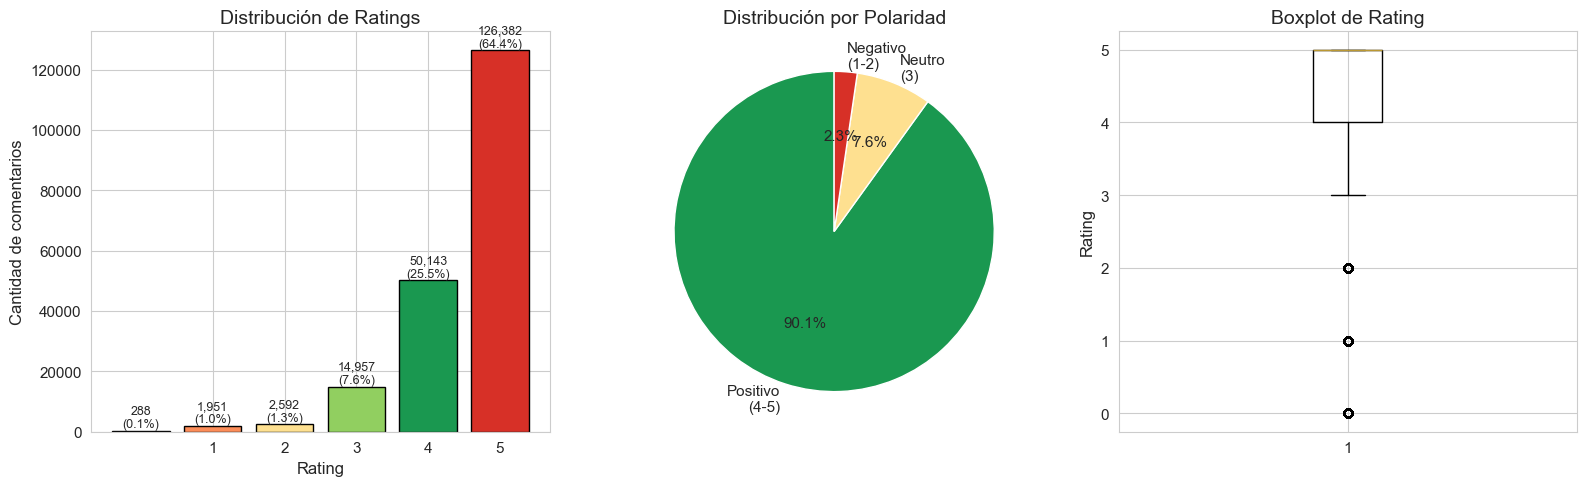

✓ Gráfico guardado


In [32]:
# ============================================================================
# FASE 3.1b: VISUALIZACIÓN DE RATING
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Gráfico de barras
colors = ['#d73027', '#fc8d59', '#fee090', '#91cf60', '#1a9850']
ax1 = axes[0]
bars = ax1.bar(rating_counts.index.astype(int), rating_counts.values, 
               color=colors, edgecolor='black')
ax1.set_xlabel('Rating')
ax1.set_ylabel('Cantidad de comentarios')
ax1.set_title('Distribución de Ratings')
ax1.set_xticks([1, 2, 3, 4, 5])

for bar, count, pct in zip(bars, rating_counts.values, rating_pcts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
             f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=9)

# Gráfico de pastel
ax2 = axes[1]
polaridad_data = [n_pos, n_neu, n_neg]
polaridad_labels = ['Positivo\n(4-5)', 'Neutro\n(3)', 'Negativo\n(1-2)']
polaridad_colors = ['#1a9850', '#fee090', '#d73027']
ax2.pie(polaridad_data, labels=polaridad_labels, colors=polaridad_colors,
        autopct='%1.1f%%', startangle=90)
ax2.set_title('Distribución por Polaridad')

# Boxplot
ax3 = axes[2]
ax3.boxplot(df['Rating_usuario'].dropna(), vert=True)
ax3.set_ylabel('Rating')
ax3.set_title('Boxplot de Rating')

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/eda_general/rating_distribution.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Gráfico guardado")

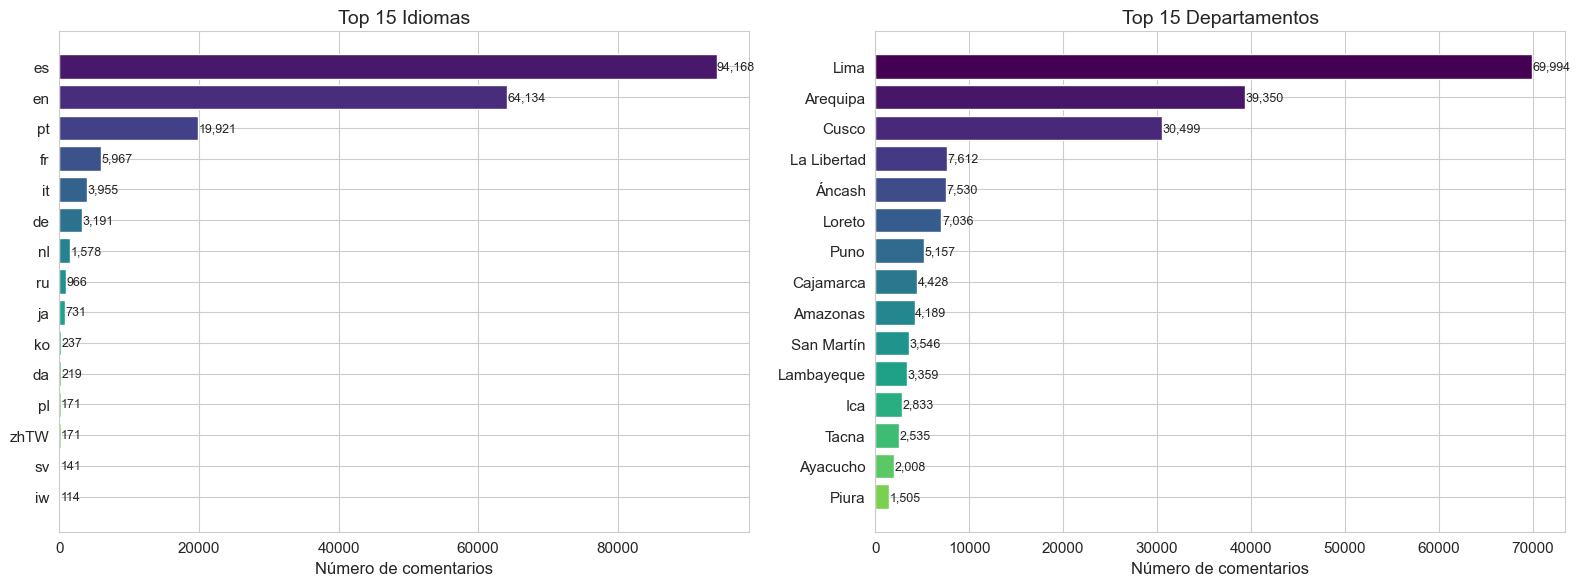


📋 Top idiomas:
   - es: 94,168
   - en: 64,134
   - pt: 19,921
   - fr: 5,967
   - it: 3,955

📋 Top departamentos:
   - Lima: 69,994
   - Arequipa: 39,350
   - Cusco: 30,499
   - La Libertad: 7,612
   - Áncash: 7,530


In [33]:
# ============================================================================
# FASE 3.2: DISTRIBUCIÓN DE IDIOMA Y DEPARTAMENTO
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Idiomas
ax1 = axes[0]
idioma_counts = df['Idioma_comentario'].value_counts().head(15)
y_pos = range(len(idioma_counts))
ax1.barh(y_pos, idioma_counts.values, color=sns.color_palette('viridis', len(idioma_counts)))
ax1.set_yticks(y_pos)
ax1.set_yticklabels(idioma_counts.index)
ax1.invert_yaxis()
ax1.set_xlabel('Número de comentarios')
ax1.set_title('Top 15 Idiomas')
for i, v in enumerate(idioma_counts.values):
    ax1.text(v + 50, i, f'{v:,}', va='center', fontsize=9)

# Departamentos
ax2 = axes[1]
depto_counts = df['DEPARTAMENTO'].value_counts().head(15)
y_pos = range(len(depto_counts))
ax2.barh(y_pos, depto_counts.values, color=plt.cm.viridis(np.linspace(0, 0.8, len(depto_counts))))
ax2.set_yticks(y_pos)
ax2.set_yticklabels(depto_counts.index)
ax2.invert_yaxis()
ax2.set_xlabel('Número de comentarios')
ax2.set_title('Top 15 Departamentos')
for i, v in enumerate(depto_counts.values):
    ax2.text(v + 50, i, f'{v:,}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/eda_general/idioma_departamento.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n📋 Top idiomas:")
for idioma, count in idioma_counts.head(5).items():
    print(f"   - {idioma}: {count:,}")

print("\n📋 Top departamentos:")
for depto, count in depto_counts.head(5).items():
    print(f"   - {depto}: {count:,}")

ANÁLISIS TEMPORAL


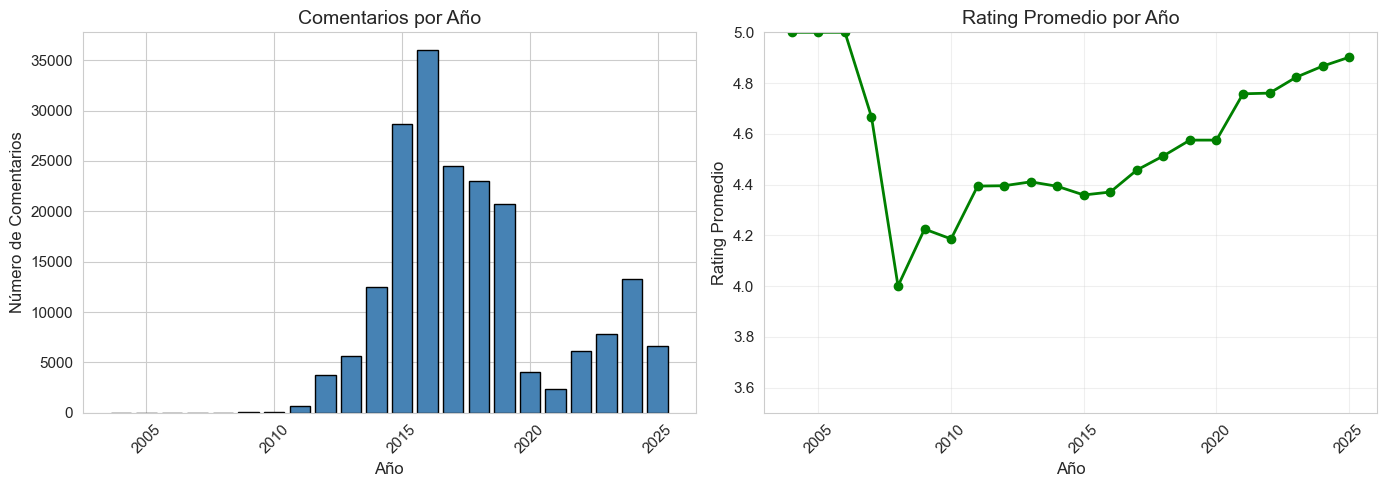


📊 Rango de fechas: 2004-08-27 00:00:00 a 2025-07-02 00:00:00


In [34]:
# ============================================================================
# FASE 3.3: ANÁLISIS TEMPORAL
# ============================================================================

print("="*60)
print("ANÁLISIS TEMPORAL")
print("="*60)

df['año_mes'] = df['Fecha_publicacion'].dt.to_period('M').astype(str)

# Comentarios por año
comentarios_año = df.groupby('AÑO').size().reset_index(name='n_comentarios')
rating_año = df.groupby('AÑO')['Rating_usuario'].mean().reset_index(name='rating_promedio')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Por año
ax1 = axes[0]
ax1.bar(comentarios_año['AÑO'], comentarios_año['n_comentarios'], color='steelblue', edgecolor='black')
ax1.set_xlabel('Año')
ax1.set_ylabel('Número de Comentarios')
ax1.set_title('Comentarios por Año')
ax1.tick_params(axis='x', rotation=45)

# Rating por año
ax2 = axes[1]
ax2.plot(rating_año['AÑO'], rating_año['rating_promedio'], marker='o', linewidth=2, color='green')
ax2.set_xlabel('Año')
ax2.set_ylabel('Rating Promedio')
ax2.set_title('Rating Promedio por Año')
ax2.set_ylim([3.5, 5])
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/eda_general/temporal_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Rango de fechas: {df['Fecha_publicacion'].min()} a {df['Fecha_publicacion'].max()}")

---
# 📝 FASE 4: EDA de Texto Multilingüe
---

In [35]:
# ============================================================================
# FASE 4.1: CALIDAD BÁSICA DE COMENTARIOS
# ============================================================================

print("="*60)
print("CALIDAD BÁSICA DE COMENTARIOS")
print("="*60)

df['tiene_comentario'] = df['Comentario'].notna() & (df['Comentario'].str.len() > 0)
n_con = df['tiene_comentario'].sum()
n_sin = (~df['tiene_comentario']).sum()

print(f"\n📝 Estado de Comentario:")
print(f"   ✓ Con comentario: {n_con:,} ({n_con/len(df)*100:.1f}%)")
print(f"   ✗ Sin comentario: {n_sin:,} ({n_sin/len(df)*100:.1f}%)")

# Longitud
df['longitud_caracteres'] = df['Comentario'].fillna('').str.len()
df['longitud_palabras'] = df['Comentario'].fillna('').str.split().str.len()

df_valid = df[df['tiene_comentario']].copy()

print("\n📊 Estadísticas de longitud:")
print(f"   - Media palabras: {df_valid['longitud_palabras'].mean():.1f}")
print(f"   - Mediana palabras: {df_valid['longitud_palabras'].median():.0f}")
print(f"   - Máx palabras: {df_valid['longitud_palabras'].max():.0f}")

CALIDAD BÁSICA DE COMENTARIOS

📝 Estado de Comentario:
   ✓ Con comentario: 196,025 (99.9%)
   ✗ Sin comentario: 288 (0.1%)

📊 Estadísticas de longitud:
   - Media palabras: 58.8
   - Mediana palabras: 39
   - Máx palabras: 2902



📋 Distribución por longitud:
   - medio: 99,956 (50.9%)
   - largo: 95,018 (48.4%)
   - corto: 1,051 (0.5%)
   - sin_comentario: 288 (0.1%)


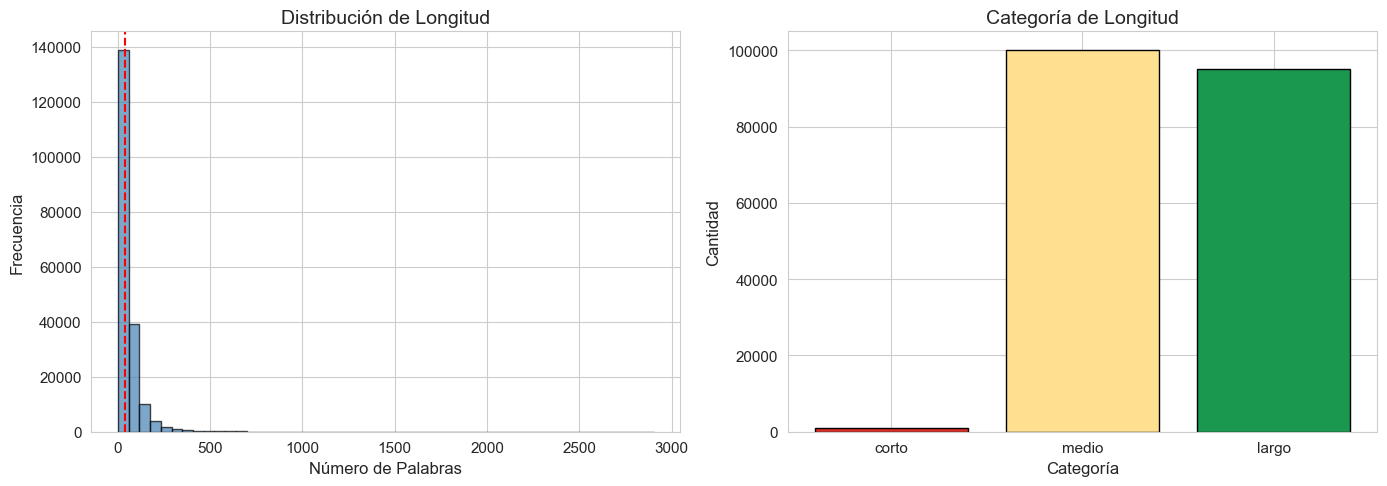

In [36]:
# ============================================================================
# FASE 4.2: CATEGORIZACIÓN POR LONGITUD
# ============================================================================

def categorizar_longitud(n_palabras):
    if pd.isna(n_palabras) or n_palabras == 0:
        return 'sin_comentario'
    elif n_palabras <= 10:
        return 'corto'
    elif n_palabras <= 40:
        return 'medio'
    else:
        return 'largo'

df['categoria_longitud'] = df['longitud_palabras'].apply(categorizar_longitud)

cat_counts = df['categoria_longitud'].value_counts()
print("\n📋 Distribución por longitud:")
for cat, count in cat_counts.items():
    pct = count / len(df) * 100
    print(f"   - {cat}: {count:,} ({pct:.1f}%)")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
df_valid['longitud_palabras'].hist(bins=50, ax=ax1, color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Número de Palabras')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución de Longitud')
ax1.axvline(df_valid['longitud_palabras'].median(), color='red', linestyle='--')

ax2 = axes[1]
order = ['corto', 'medio', 'largo']
colors = ['#d73027', '#fee090', '#1a9850']
cat_plot = df[df['categoria_longitud'].isin(order)]['categoria_longitud'].value_counts().reindex(order)
ax2.bar(cat_plot.index, cat_plot.values, color=colors, edgecolor='black')
ax2.set_xlabel('Categoría')
ax2.set_ylabel('Cantidad')
ax2.set_title('Categoría de Longitud')

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/eda_text/longitud.png", dpi=150, bbox_inches='tight')
plt.show()

In [37]:
# ============================================================================
# FASE 4.3: VERIFICACIÓN DE IDIOMA (MUESTRA)
# ============================================================================

if LANGDETECT_AVAILABLE:
    print("="*60)
    print("VERIFICACIÓN DE IDIOMA")
    print("="*60)
    
    def detect_language_safe(text):
        try:
            if pd.isna(text) or len(str(text).strip()) < 10:
                return None
            return detect(str(text))
        except:
            return None
    
    sample_size = min(500, len(df_valid))
    df_sample = df_valid.sample(sample_size, random_state=RANDOM_STATE).copy()
    
    print(f"\n⏳ Detectando idioma en {sample_size} comentarios...")
    df_sample['idioma_detectado'] = df_sample['Comentario'].apply(detect_language_safe)
    
    df_check = df_sample[df_sample['idioma_detectado'].notna()].copy()
    df_check['coincide'] = df_check['Idioma_comentario'] == df_check['idioma_detectado']
    
    n_coincide = df_check['coincide'].sum()
    print(f"\n📊 Coincidencia idioma declarado vs detectado:")
    print(f"   - Coincide: {n_coincide} ({n_coincide/len(df_check)*100:.1f}%)")
    print(f"   - No coincide: {len(df_check)-n_coincide} ({(len(df_check)-n_coincide)/len(df_check)*100:.1f}%)")
else:
    print("⚠️ langdetect no disponible para verificación de idioma")

VERIFICACIÓN DE IDIOMA

⏳ Detectando idioma en 500 comentarios...

📊 Coincidencia idioma declarado vs detectado:
   - Coincide: 500 (100.0%)
   - No coincide: 0 (0.0%)


In [38]:
# ============================================================================
# FASE 4.4: PALABRAS FRECUENTES POR IDIOMA
# ============================================================================

print("="*60)
print("PALABRAS FRECUENTES POR IDIOMA")
print("="*60)

def limpiar_texto_basico(texto):
    if pd.isna(texto):
        return ''
    texto = str(texto).lower()
    texto = re.sub(r'[^\w\s]', ' ', texto)
    texto = re.sub(r'\d+', '', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

def obtener_top_palabras(textos, n=20, stopwords=None):
    if stopwords is None:
        stopwords = set()
    all_words = []
    for texto in textos:
        words = limpiar_texto_basico(texto).split()
        all_words.extend([w for w in words if len(w) > 2 and w not in stopwords])
    return Counter(all_words).most_common(n)

# Stopwords
stopwords_es = {'que', 'de', 'la', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 
                'para', 'con', 'no', 'una', 'su', 'al', 'es', 'lo', 'como', 'más', 'pero', 'sus',
                'muy', 'fue', 'son', 'hay', 'esta', 'ser', 'tiene', 'todo', 'nos', 'era', 'puede'}
stopwords_en = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with',
                'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had', 'this', 'that',
                'it', 'we', 'you', 'they', 'very', 'not', 'our', 'your', 'can', 'will', 'just'}

for idioma, stopwords in [('es', stopwords_es), ('en', stopwords_en)]:
    textos = df_valid[df_valid['Idioma_comentario'] == idioma]['Comentario'].tolist()
    if len(textos) > 50:
        top = obtener_top_palabras(textos, n=15, stopwords=stopwords)
        print(f"\n🔤 Top palabras en {idioma.upper()} ({len(textos):,} comentarios):")
        for i, (palabra, freq) in enumerate(top, 1):
            print(f"   {i:2d}. {palabra:<12} {freq:>5,}")

PALABRAS FRECUENTES POR IDIOMA

🔤 Top palabras en ES (94,168 comentarios):
    1. lugar        31,367
    2. bien         13,936
    3. ciudad       12,700
    4. este         12,236
    5. lima         12,017
    6. plaza        11,771
    7. donde        11,330
    8. historia     10,071
    9. visitar      10,002
   10. desde        9,992
   11. experiencia  9,950
   12. visita       9,752
   13. guía         9,511
   14. excelente    9,350
   15. ver          9,349

🔤 Top palabras en EN (64,134 comentarios):
    1. tour         34,602
    2. guide        27,764
    3. great        23,625
    4. all          23,623
    5. there        23,508
    6. from         23,493
    7. day          20,122
    8. about        18,644
    9. time         17,619
   10. experience   16,919
   11. trip         16,763
   12. amazing      15,702
   13. well         15,026
   14. one          14,650
   15. also         14,182


---
# 🎯 FASE 5: Diseño del Esquema de Sentimiento
---

In [39]:
# ============================================================================
# FASE 5.1: DEFINICIÓN DE COLUMNAS DE SENTIMIENTO
# ============================================================================

print("="*60)
print("ESQUEMA DE COLUMNAS DE SENTIMIENTO")
print("="*60)

SENTIMENT_SCHEMA = {
    'sentiment_score_model_trf': 'Score continuo (-1 a +1)',
    'sentiment_label_model_trf_3clases': 'Etiqueta: negativo/neutro/positivo',
    'sentiment_confidence_model_trf': 'Confianza del modelo (0-1)',
    'sentiment_raw_label_model_trf': 'Etiqueta cruda del modelo',
    'sentiment_label_proxy_rating_3clases': 'Proxy basado en Rating_usuario'
}

print("\n📋 Columnas de sentimiento a crear:")
for col, desc in SENTIMENT_SCHEMA.items():
    print(f"   • {col}")
    print(f"     └─ {desc}")

# Crear proxy de rating
def rating_to_sentiment_proxy(rating):
    if pd.isna(rating):
        return np.nan
    elif rating <= 2:
        return 'negativo'
    elif rating == 3:
        return 'neutro'
    else:
        return 'positivo'

df['sentiment_label_proxy_rating_3clases'] = df['Rating_usuario'].apply(rating_to_sentiment_proxy)

proxy_counts = df['sentiment_label_proxy_rating_3clases'].value_counts()
print("\n📊 Distribución del proxy:")
for label, count in proxy_counts.items():
    emoji = '🔴' if label == 'negativo' else ('🟡' if label == 'neutro' else '🟢')
    print(f"   {emoji} {label}: {count:,} ({count/proxy_counts.sum()*100:.1f}%)")

ESQUEMA DE COLUMNAS DE SENTIMIENTO

📋 Columnas de sentimiento a crear:
   • sentiment_score_model_trf
     └─ Score continuo (-1 a +1)
   • sentiment_label_model_trf_3clases
     └─ Etiqueta: negativo/neutro/positivo
   • sentiment_confidence_model_trf
     └─ Confianza del modelo (0-1)
   • sentiment_raw_label_model_trf
     └─ Etiqueta cruda del modelo
   • sentiment_label_proxy_rating_3clases
     └─ Proxy basado en Rating_usuario

📊 Distribución del proxy:
   🟢 positivo: 176,525 (89.9%)
   🟡 neutro: 14,957 (7.6%)
   🔴 negativo: 4,831 (2.5%)


---
# 🤖 FASE 6: Generación de Sentimientos (Transformer Multilingüe)
---

In [40]:
# ============================================================================
# FASE 6.1: PREPARACIÓN Y CARGA DEL MODELO
# ============================================================================

print("="*60)
print("MODELO DE SENTIMIENTO MULTILINGÜE")
print("="*60)

# Preparar textos
def preparar_texto_modelo(texto, max_chars=1000):
    if pd.isna(texto) or str(texto).strip() == '':
        return None
    texto = str(texto).strip()
    if len(texto) > max_chars:
        texto = texto[:max_chars]
    return texto

df['texto_modelo'] = df['Comentario'].apply(preparar_texto_modelo)

n_validos = df['texto_modelo'].notna().sum()
print(f"\n📊 Textos preparados: {n_validos:,} válidos para modelo")

if TRANSFORMERS_AVAILABLE:
    MODEL_NAME = MODEL_CONFIG['sentiment_multilingual']
    BATCH_SIZE = MODEL_CONFIG['batch_size_gpu'] if torch.cuda.is_available() else MODEL_CONFIG['batch_size_cpu']
    
    print(f"\n🧠 Modelo: {MODEL_NAME}")
    print(f"🖥️  Dispositivo: {DEVICE}")
    print(f"📦 Batch size: {BATCH_SIZE}")
    
    print("\n⏳ Cargando modelo...")
    t_start = time.time()
    
    try:
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, use_safetensors=True)
        
        if torch.cuda.is_available():
            model = model.to(DEVICE)
            torch.backends.cudnn.benchmark = True
        model.eval()
        
        sentiment_pipeline = pipeline(
            "text-classification", model=model, tokenizer=tokenizer,
            device=DEVICE_ID, truncation=True, max_length=256, padding=True
        )
        print(f"✓ Modelo cargado en {time.time()-t_start:.2f}s")
        MODEL_LOADED = True
    except Exception as e:
        print(f"❌ Error: {e}")
        print("Intentando modelo alternativo...")
        try:
            MODEL_NAME = MODEL_CONFIG['sentiment_alternative']
            tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
            model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
            if torch.cuda.is_available():
                model = model.to(DEVICE)
            model.eval()
            sentiment_pipeline = pipeline(
                "text-classification", model=model, tokenizer=tokenizer,
                device=DEVICE_ID, truncation=True, max_length=256, padding=True
            )
            print(f"✓ Modelo alternativo cargado: {MODEL_NAME}")
            MODEL_LOADED = True
        except Exception as e2:
            print(f"❌ Error con modelo alternativo: {e2}")
            MODEL_LOADED = False
else:
    MODEL_LOADED = False
    print("⚠️ Transformers no disponible")

MODELO DE SENTIMIENTO MULTILINGÜE

📊 Textos preparados: 196,025 válidos para modelo

🧠 Modelo: clapAI/roberta-large-multilingual-sentiment
🖥️  Dispositivo: cuda
📦 Batch size: 64

⏳ Cargando modelo...


Device set to use cuda:0


✓ Modelo cargado en 2.29s


In [41]:
# ============================================================================
# FASE 6.2: INFERENCIA OPTIMIZADA CON DATASET (5-10x MÁS RÁPIDO)
# ============================================================================

from datasets import Dataset as HFDataset

if MODEL_LOADED:
    print("="*60)
    print("INFERENCIA DE SENTIMIENTO (OPTIMIZADA)")
    print("="*60)
    
    # 1. Filtrar textos válidos
    df['_idx'] = range(len(df))
    df_valid_texts = df[df['texto_modelo'].notna() & (df['texto_modelo'].str.strip() != '')].copy()
    textos_validos = df_valid_texts['texto_modelo'].tolist()
    indices_validos = df_valid_texts['_idx'].tolist()
    
    print(f"\n📝 Textos válidos a procesar: {len(textos_validos):,}")
    
    # 2. Crear Dataset de HuggingFace (CLAVE para velocidad)
    hf_dataset = HFDataset.from_dict({"text": textos_validos})
    
    # 3. Configurar pipeline OPTIMIZADO
    BATCH_SIZE_OPTIMIZED = 768  # Aumentar a 256 si tienes >12GB VRAM
    
    # Usar FP16 para acelerar (si GPU)
    if torch.cuda.is_available():
        model = model.half()  # FP16
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
    
    sentiment_pipeline_fast = pipeline(
        "text-classification",
        model=model,
        tokenizer=tokenizer,
        device=DEVICE_ID,
        truncation=True,
        max_length=256,
        batch_size=BATCH_SIZE_OPTIMIZED  # ← ESTO ES CLAVE
    )
    
    print(f"🚀 Batch size: {BATCH_SIZE_OPTIMIZED}")
    print(f"⚡ Usando FP16: {torch.cuda.is_available()}")
    
    # 4. Procesar con Dataset (usa batching REAL)
    print("\n⏳ Procesando...")
    t_start = time.time()
    
    # Esta línea usa batching REAL en GPU
    resultados_raw = []
    for out in tqdm(sentiment_pipeline_fast(hf_dataset["text"], batch_size=BATCH_SIZE_OPTIMIZED), 
                    total=len(textos_validos), desc="Inferencia"):
        resultados_raw.append(out)
    
    t_elapsed = time.time() - t_start
    print(f"\n✓ Completado en {timedelta(seconds=int(t_elapsed))}")
    print(f"⚡ Velocidad: {len(textos_validos)/t_elapsed:.1f} textos/s")
    
    # 5. Mapear resultados
    def mapear_etiqueta(raw_label):
        raw_label = str(raw_label).lower()
        if raw_label in ['negative', 'negativo', '1 star', '2 stars', '1', '2']:
            return 'negativo', -1.0
        elif raw_label in ['neutral', 'neutro', '3 stars', '3']:
            return 'neutro', 0.0
        elif raw_label in ['positive', 'positivo', '4 stars', '5 stars', '4', '5']:
            return 'positivo', 1.0
        else:
            try:
                stars = int(raw_label.split()[0])
                if stars <= 2: return 'negativo', -1.0
                elif stars == 3: return 'neutro', 0.0
                else: return 'positivo', 1.0
            except:
                return 'neutro', 0.0
    
    # 6. Crear arrays de resultados
    n_total = len(df)
    sentiment_raw = [np.nan] * n_total
    sentiment_conf = [np.nan] * n_total
    sentiment_label = [np.nan] * n_total
    sentiment_score = [np.nan] * n_total
    
    for idx, res in zip(indices_validos, resultados_raw):
        label_3, polarity = mapear_etiqueta(res['label'])
        sentiment_raw[idx] = res['label']
        sentiment_conf[idx] = res['score']
        sentiment_label[idx] = label_3
        sentiment_score[idx] = polarity
    
    # 7. Agregar al DataFrame
    df['sentiment_raw_label_model_trf'] = sentiment_raw
    df['sentiment_confidence_model_trf'] = sentiment_conf
    df['sentiment_label_model_trf_3clases'] = sentiment_label
    df['sentiment_score_model_trf'] = sentiment_score
    
    # Limpiar
    df.drop('_idx', axis=1, inplace=True)
    
    # Resumen
    print("\n📊 Distribución de sentimiento:")
    for label in ['negativo', 'neutro', 'positivo']:
        count = (df['sentiment_label_model_trf_3clases'] == label).sum()
        pct = count / df['sentiment_label_model_trf_3clases'].notna().sum() * 100
        emoji = '🔴' if label == 'negativo' else ('🟡' if label == 'neutro' else '🟢')
        print(f"   {emoji} {label}: {count:,} ({pct:.1f}%)")

INFERENCIA DE SENTIMIENTO (OPTIMIZADA)

📝 Textos válidos a procesar: 196,025


Device set to use cuda:0


🚀 Batch size: 768
⚡ Usando FP16: True

⏳ Procesando...


ValueError: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).

In [ ]:
# # ============================================================================
# # FASE 6.2: FUNCIÓN DE INFERENCIA POR LOTES
# # ============================================================================

# def procesar_sentimiento_batch(textos, pipeline_model, batch_size=32):
#     resultados = []
#     n_textos = len(textos)
#     n_batches = int(np.ceil(n_textos / batch_size))
    
#     for i in tqdm(range(n_batches), desc="Procesando"):
#         start_idx = i * batch_size
#         end_idx = min(start_idx + batch_size, n_textos)
#         batch_textos = textos[start_idx:end_idx]
        
#         batch_validos = [(j, t) for j, t in enumerate(batch_textos) if t is not None and t.strip()]
#         batch_results = [None] * len(batch_textos)
        
#         if batch_validos:
#             indices, textos_procesar = zip(*batch_validos)
#             try:
#                 predicciones = pipeline_model(list(textos_procesar))
#                 for idx, pred in zip(indices, predicciones):
#                     raw_label = str(pred['label']).lower()
#                     score = float(pred['score'])
                    
#                     # Mapeo a 3 clases
#                     if raw_label in ['negative', 'negativo', '1 star', '2 stars', '1', '2']:
#                         label_3clases, polarity = 'negativo', -1.0
#                     elif raw_label in ['neutral', 'neutro', '3 stars', '3']:
#                         label_3clases, polarity = 'neutro', 0.0
#                     elif raw_label in ['positive', 'positivo', '4 stars', '5 stars', '4', '5']:
#                         label_3clases, polarity = 'positivo', 1.0
#                     else:
#                         try:
#                             stars = int(raw_label.split()[0])
#                             if stars <= 2: label_3clases, polarity = 'negativo', -1.0
#                             elif stars == 3: label_3clases, polarity = 'neutro', 0.0
#                             else: label_3clases, polarity = 'positivo', 1.0
#                         except:
#                             label_3clases, polarity = 'neutro', 0.0
                    
#                     batch_results[idx] = {
#                         'raw_label': raw_label, 'confidence': score,
#                         'label_3clases': label_3clases, 'polarity_score': polarity
#                     }
#             except Exception as e:
#                 print(f"Error batch {i}: {e}")
        
#         resultados.extend(batch_results)
#     return resultados

# print("✓ Función de inferencia definida")

✓ Función de inferencia definida


In [ ]:
# # ============================================================================
# # FASE 6.3: EJECUTAR INFERENCIA
# # ============================================================================

# if MODEL_LOADED:
#     print("="*60)
#     print("INFERENCIA DE SENTIMIENTO")
#     print("="*60)
    
#     textos_lista = df['texto_modelo'].tolist()
#     print(f"\n📝 Textos a procesar: {len(textos_lista):,}")
    
#     t_start = time.time()
#     resultados_sentimiento = procesar_sentimiento_batch(textos_lista, sentiment_pipeline, batch_size=BATCH_SIZE)
#     t_elapsed = time.time() - t_start
    
#     print(f"\n✓ Inferencia completada en {timedelta(seconds=int(t_elapsed))}")
#     print(f"⚡ Velocidad: {len(textos_lista)/t_elapsed:.1f} textos/s")
    
#     # Agregar resultados
#     df['sentiment_raw_label_model_trf'] = [r['raw_label'] if r else np.nan for r in resultados_sentimiento]
#     df['sentiment_confidence_model_trf'] = [r['confidence'] if r else np.nan for r in resultados_sentimiento]
#     df['sentiment_label_model_trf_3clases'] = [r['label_3clases'] if r else np.nan for r in resultados_sentimiento]
#     df['sentiment_score_model_trf'] = [r['polarity_score'] if r else np.nan for r in resultados_sentimiento]
    
#     # Resumen
#     print("\n📊 Distribución de sentimiento:")
#     for label in ['negativo', 'neutro', 'positivo']:
#         count = (df['sentiment_label_model_trf_3clases'] == label).sum()
#         pct = count / df['sentiment_label_model_trf_3clases'].notna().sum() * 100
#         emoji = '🔴' if label == 'negativo' else ('🟡' if label == 'neutro' else '🟢')
#         print(f"   {emoji} {label}: {count:,} ({pct:.1f}%)")
# else:
#     print("⚠️ Modelo no cargado - usando proxy de rating como sentimiento")
#     df['sentiment_label_model_trf_3clases'] = df['sentiment_label_proxy_rating_3clases']
#     df['sentiment_confidence_model_trf'] = 1.0
#     df['sentiment_score_model_trf'] = df['Rating_usuario'].apply(
#         lambda x: -1.0 if x <= 2 else (0.0 if x == 3 else 1.0) if pd.notna(x) else np.nan
#     )
#     df['sentiment_raw_label_model_trf'] = df['sentiment_label_model_trf_3clases']

INFERENCIA DE SENTIMIENTO

📝 Textos a procesar: 196,313


Procesando:  63%|██████▎   | 1936/3068 [43:24<25:23,  1.35s/it] 


KeyboardInterrupt: 

In [ ]:
# ============================================================================
# FASE 6.4: VISUALIZACIÓN DE RESULTADOS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribución
ax1 = axes[0, 0]
colors_sent = {'negativo': '#d73027', 'neutro': '#fee090', 'positivo': '#1a9850'}
sent_counts = df['sentiment_label_model_trf_3clases'].value_counts()
ax1.bar(sent_counts.index, sent_counts.values, 
        color=[colors_sent.get(x, 'gray') for x in sent_counts.index], edgecolor='black')
ax1.set_xlabel('Sentimiento')
ax1.set_ylabel('Cantidad')
ax1.set_title('Distribución de Sentimiento')

# 2. Confianza
ax2 = axes[0, 1]
df['sentiment_confidence_model_trf'].hist(bins=50, ax=ax2, color='steelblue', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Confianza')
ax2.set_ylabel('Frecuencia')
ax2.set_title('Distribución de Confianza')

# 3. Matriz modelo vs proxy
ax3 = axes[1, 0]
try:
    comparison = pd.crosstab(df['sentiment_label_proxy_rating_3clases'], 
                             df['sentiment_label_model_trf_3clases'], normalize='index') * 100
    comparison = comparison.reindex(index=['negativo', 'neutro', 'positivo'], 
                                    columns=['negativo', 'neutro', 'positivo'])
    sns.heatmap(comparison, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax3)
    ax3.set_xlabel('Modelo')
    ax3.set_ylabel('Proxy (Rating)')
    ax3.set_title('Matriz: Proxy vs Modelo (%)')
except:
    ax3.text(0.5, 0.5, 'No disponible', ha='center', va='center')

# 4. Confianza por clase
ax4 = axes[1, 1]
try:
    df.boxplot(column='sentiment_confidence_model_trf', by='sentiment_label_model_trf_3clases', ax=ax4)
    ax4.set_xlabel('Sentimiento')
    ax4.set_ylabel('Confianza')
    ax4.set_title('Confianza por Clase')
    plt.suptitle('')
except:
    pass

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/eda_text/sentiment_results.png", dpi=150, bbox_inches='tight')
plt.show()

---
# 📊 FASE 7: Modelo Baseline (TF-IDF + Clasificador)
---

In [ ]:
# ============================================================================
# FASE 7.1: PREPARACIÓN DE DATOS
# ============================================================================

print("="*60)
print("MODELO BASELINE: TF-IDF + LOGISTIC REGRESSION")
print("="*60)

df_baseline = df[df['tiene_comentario'] & df['sentiment_label_proxy_rating_3clases'].notna()].copy()
print(f"\n📊 Datos para entrenamiento: {len(df_baseline):,}")

# División
X = df_baseline['Comentario'].values
y = df_baseline['sentiment_label_proxy_rating_3clases'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print(f"   - Train: {len(X_train):,}")
print(f"   - Test: {len(X_test):,}")

In [ ]:
# ============================================================================
# FASE 7.2: ENTRENAMIENTO Y EVALUACIÓN
# ============================================================================

print("\n⏳ Entrenando modelo...")
t_start = time.time()

# TF-IDF
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=10000, min_df=3, max_df=0.95, sublinear_tf=True)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"   - Vocabulario: {len(tfidf.vocabulary_):,} términos")

# Logistic Regression
clf_lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)
clf_lr.fit(X_train_tfidf, y_train)

print(f"✓ Modelo entrenado en {time.time()-t_start:.2f}s")

# Evaluación
y_pred = clf_lr.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print(f"\n📊 Métricas Baseline:")
print(f"   - Accuracy: {accuracy:.4f}")
print(f"   - F1 Macro: {f1:.4f}")
print(f"\n📋 Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# ============================================================================
# FASE 7.3: PALABRAS MÁS IMPORTANTES
# ============================================================================

print("="*60)
print("PALABRAS MÁS IMPORTANTES POR CLASE")
print("="*60)

feature_names = np.array(tfidf.get_feature_names_out())

for i, cls in enumerate(clf_lr.classes_):
    coefs = clf_lr.coef_[i]
    top_idx = coefs.argsort()[-10:][::-1]
    top_words = feature_names[top_idx]
    
    emoji = '🔴' if cls == 'negativo' else ('🟡' if cls == 'neutro' else '🟢')
    print(f"\n{emoji} {cls.upper()}:")
    print(f"   {', '.join(top_words[:10])}")

---
# 🔍 FASE 8: ABSA - Análisis de Sentimiento por Aspectos
---

In [ ]:
# ============================================================================
# FASE 8.1: DEFINICIÓN DE ASPECTOS TURÍSTICOS
# ============================================================================

print("="*60)
print("ABSA: ANÁLISIS DE SENTIMIENTO POR ASPECTOS")
print("="*60)

ASPECTOS_TURISMO = {
    'infraestructura': {
        'keywords': ['hotel', 'habitación', 'habitacion', 'instalaciones', 'baño', 'cama', 
                    'alojamiento', 'hospedaje', 'hostel', 'wifi', 'piscina', 'room', 'bed']
    },
    'servicio': {
        'keywords': ['servicio', 'atención', 'atencion', 'personal', 'staff', 'guía', 'guia',
                    'amable', 'trato', 'ayuda', 'service', 'friendly', 'helpful']
    },
    'ubicacion': {
        'keywords': ['ubicación', 'ubicacion', 'lugar', 'zona', 'acceso', 'transporte', 'centro',
                    'lejos', 'cerca', 'location', 'central', 'distance']
    },
    'precio': {
        'keywords': ['precio', 'costo', 'caro', 'barato', 'económico', 'valor', 'dinero',
                    'price', 'cost', 'expensive', 'cheap', 'value']
    },
    'limpieza': {
        'keywords': ['limpio', 'limpieza', 'sucio', 'aseo', 'higiene', 'olor',
                    'clean', 'dirty', 'hygiene', 'smell']
    },
    'seguridad': {
        'keywords': ['seguro', 'seguridad', 'peligro', 'peligroso', 'robo', 'policía',
                    'safe', 'safety', 'danger', 'dangerous', 'theft']
    },
    'comida': {
        'keywords': ['comida', 'desayuno', 'almuerzo', 'cena', 'restaurante', 'plato', 'menú',
                    'rico', 'delicioso', 'food', 'breakfast', 'delicious']
    },
    'experiencia': {
        'keywords': ['experiencia', 'aventura', 'tour', 'excursión', 'visita', 'paseo',
                    'increíble', 'recomiendo', 'experience', 'amazing', 'recommend']
    }
}

print("\n📋 Aspectos definidos:")
for asp, info in ASPECTOS_TURISMO.items():
    print(f"   • {asp}: {len(info['keywords'])} keywords")

In [ ]:
# ============================================================================
# FASE 8.2: DETECCIÓN DE ASPECTOS
# ============================================================================

print("\n⏳ Detectando aspectos...")

def detectar_aspectos(texto):
    if pd.isna(texto):
        return {}
    texto_lower = str(texto).lower()
    aspectos_presentes = {}
    for aspecto, config in ASPECTOS_TURISMO.items():
        for kw in config['keywords']:
            if kw.lower() in texto_lower:
                aspectos_presentes[aspecto] = True
                break
    return aspectos_presentes

df['_aspectos'] = df['Comentario'].apply(detectar_aspectos)

# Crear columnas booleanas
for aspecto in ASPECTOS_TURISMO.keys():
    df[f'_menciona_{aspecto}'] = df['_aspectos'].apply(lambda x: aspecto in x if x else False)

print("\n📊 Frecuencia de mención de aspectos:")
for aspecto in ASPECTOS_TURISMO.keys():
    n = df[f'_menciona_{aspecto}'].sum()
    pct = n / len(df) * 100
    bar = "█" * int(pct / 2)
    print(f"   {aspecto:<15}: {n:>6,} ({pct:>5.1f}%) {bar}")

In [ ]:
# ============================================================================
# FASE 8.3: SENTIMIENTO POR ASPECTO (SIMPLIFICADO)
# ============================================================================

# Método simplificado: usar el sentimiento global para comentarios que mencionan cada aspecto

print("\n📊 Sentimiento promedio por aspecto:")
aspect_sentiment = []

for aspecto in ASPECTOS_TURISMO.keys():
    mask = df[f'_menciona_{aspecto}'] & df['sentiment_score_model_trf'].notna()
    if mask.sum() > 0:
        sent_mean = df.loc[mask, 'sentiment_score_model_trf'].mean()
        n_menciones = mask.sum()
        pct_pos = (df.loc[mask, 'sentiment_label_model_trf_3clases'] == 'positivo').mean() * 100
        pct_neg = (df.loc[mask, 'sentiment_label_model_trf_3clases'] == 'negativo').mean() * 100
        
        aspect_sentiment.append({
            'aspecto': aspecto, 'n_menciones': n_menciones,
            'sent_promedio': sent_mean, 'pct_positivo': pct_pos, 'pct_negativo': pct_neg
        })
        
        # Crear columna de sentimiento por aspecto
        df[f'sent_aspect_{aspecto}'] = np.where(df[f'_menciona_{aspecto}'], 
                                                 df['sentiment_score_model_trf'], np.nan)

df_aspect = pd.DataFrame(aspect_sentiment).sort_values('n_menciones', ascending=False)
display(df_aspect)

# Visualización
if len(df_aspect) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1 = axes[0]
    colors = ['green' if x > 0 else 'red' for x in df_aspect['sent_promedio']]
    ax1.barh(df_aspect['aspecto'], df_aspect['sent_promedio'], color=colors, edgecolor='black')
    ax1.axvline(0, color='black', linewidth=0.5)
    ax1.set_xlabel('Sentimiento Promedio')
    ax1.set_title('Sentimiento por Aspecto')
    ax1.set_xlim([-1, 1])
    
    ax2 = axes[1]
    ax2.barh(df_aspect['aspecto'], df_aspect['n_menciones'], color='steelblue', edgecolor='black')
    ax2.set_xlabel('Menciones')
    ax2.set_title('Frecuencia de Mención')
    
    plt.tight_layout()
    plt.savefig(f"{FIGURES_DIR}/eda_text/absa_results.png", dpi=150, bbox_inches='tight')
    plt.show()

---
# 😊 FASE 9: Modelo de Emociones
---

In [ ]:
# ============================================================================
# FASE 9.1: ANÁLISIS DE EMOCIONES BASADO EN LEXICÓN
# ============================================================================

print("="*60)
print("ANÁLISIS DE EMOCIONES")
print("="*60)

EMOTION_LEXICON = {
    'alegria': ['feliz', 'alegre', 'contento', 'encantado', 'maravilloso', 'fantástico', 'excelente',
                'genial', 'increíble', 'perfecto', 'hermoso', 'happy', 'joy', 'wonderful', 'amazing'],
    'enojo': ['furioso', 'enojado', 'molesto', 'frustrado', 'horrible', 'pésimo', 'terrible',
              'inaceptable', 'estafa', 'angry', 'furious', 'annoyed', 'frustrated'],
    'tristeza': ['triste', 'decepcionado', 'decepción', 'desilusionado', 'lamentable', 'pena',
                 'sad', 'disappointed', 'disappointing', 'unfortunate', 'regret'],
    'sorpresa': ['sorprendido', 'sorpresa', 'inesperado', 'impresionante', 'asombroso',
                 'surprised', 'unexpected', 'impressive', 'amazed', 'wow'],
    'miedo': ['miedo', 'asustado', 'peligroso', 'inseguro', 'nervioso', 'preocupado',
              'fear', 'scared', 'dangerous', 'unsafe', 'worried']
}

def calcular_emociones(texto):
    if pd.isna(texto) or not texto.strip():
        return {f'emo_{e}': np.nan for e in EMOTION_LEXICON.keys()}
    
    texto_lower = str(texto).lower()
    palabras = set(re.findall(r'\b\w+\b', texto_lower))
    n_palabras = max(len(palabras), 1)
    
    scores = {}
    for emo, keywords in EMOTION_LEXICON.items():
        matches = palabras & set(keywords)
        scores[f'emo_{emo}'] = len(matches) / n_palabras if matches else 0.0
    
    total = sum(scores.values())
    if total > 0:
        scores = {k: v/total for k, v in scores.items()}
    scores['emo_neutral'] = 1.0 - sum(scores.values()) if sum(scores.values()) < 1 else 0.0
    
    return scores

print("⏳ Calculando emociones...")
emotion_results = df['Comentario'].apply(calcular_emociones)
df_emotions = pd.DataFrame(emotion_results.tolist())

for col in df_emotions.columns:
    df[col] = df_emotions[col].values

print("\n📊 Emociones promedio detectadas:")
for emo in ['emo_alegria', 'emo_enojo', 'emo_tristeza', 'emo_sorpresa', 'emo_miedo', 'emo_neutral']:
    if emo in df.columns:
        mean_val = df[emo].mean() * 100
        print(f"   {emo.replace('emo_', '').capitalize():<12}: {mean_val:.2f}%")

print("\n✓ Columnas de emociones agregadas")

---
# 📈 FASE 10: Evaluación y Comparación de Modelos
---

In [ ]:
# ============================================================================
# FASE 10.1: EVALUACIÓN CONTRA PROXY
# ============================================================================

print("="*60)
print("EVALUACIÓN DE MODELOS")
print("="*60)

df_eval = df[df['sentiment_label_proxy_rating_3clases'].notna() & 
             df['sentiment_label_model_trf_3clases'].notna()].copy()

print(f"\n📊 Datos para evaluación: {len(df_eval):,}")

# Métricas modelo vs proxy
y_true = df_eval['sentiment_label_proxy_rating_3clases']
y_pred = df_eval['sentiment_label_model_trf_3clases']

acc_model = accuracy_score(y_true, y_pred)
f1_model = f1_score(y_true, y_pred, average='macro')

print(f"\n📊 Métricas Modelo Transformer vs Proxy:")
print(f"   - Accuracy: {acc_model:.4f}")
print(f"   - F1 Macro: {f1_model:.4f}")

print(f"\n📋 Classification Report:")
print(classification_report(y_true, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=['negativo', 'neutro', 'positivo'])
print("\n📊 Matriz de Confusión:")
print(pd.DataFrame(cm, index=['Real: neg', 'Real: neu', 'Real: pos'],
                   columns=['Pred: neg', 'Pred: neu', 'Pred: pos']))

In [ ]:
# ============================================================================
# FASE 10.2: EVALUACIÓN POR IDIOMA
# ============================================================================

print("\n📊 F1 por Idioma (idiomas con >100 comentarios):")

idiomas_eval = df_eval.groupby('Idioma_comentario').size()
idiomas_suficientes = idiomas_eval[idiomas_eval >= 100].index.tolist()

f1_por_idioma = []
for idioma in idiomas_suficientes[:10]:
    mask = df_eval['Idioma_comentario'] == idioma
    if mask.sum() > 50:
        f1 = f1_score(df_eval.loc[mask, 'sentiment_label_proxy_rating_3clases'],
                      df_eval.loc[mask, 'sentiment_label_model_trf_3clases'], average='macro')
        f1_por_idioma.append({'idioma': idioma, 'f1_macro': f1, 'n': mask.sum()})
        print(f"   {idioma}: F1={f1:.3f} (n={mask.sum():,})")

# Visualización
fig, ax = plt.subplots(figsize=(10, 5))
if f1_por_idioma:
    df_f1 = pd.DataFrame(f1_por_idioma).sort_values('f1_macro', ascending=True)
    ax.barh(df_f1['idioma'], df_f1['f1_macro'], color='steelblue', edgecolor='black')
    ax.set_xlabel('F1 Macro')
    ax.set_title('F1 por Idioma')
    ax.set_xlim([0, 1])
    plt.tight_layout()
    plt.savefig(f"{FIGURES_DIR}/eda_text/f1_por_idioma.png", dpi=150, bbox_inches='tight')
    plt.show()

In [ ]:
# ============================================================================
# FASE 10.3: COMPARACIÓN DE MODELOS
# ============================================================================

print("\n📊 COMPARACIÓN DE MODELOS")
print("="*60)

comparacion = {
    'Modelo': ['Transformer Multilingüe', 'TF-IDF + LogReg (Baseline)'],
    'Accuracy': [acc_model, accuracy],
    'F1 Macro': [f1_model, f1],
    'Tipo': ['Deep Learning', 'Machine Learning Clásico']
}
df_comparacion = pd.DataFrame(comparacion)
display(df_comparacion)

# Visualización
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(df_comparacion))
width = 0.35
ax.bar(x - width/2, df_comparacion['Accuracy'], width, label='Accuracy', color='steelblue')
ax.bar(x + width/2, df_comparacion['F1 Macro'], width, label='F1 Macro', color='coral')
ax.set_ylabel('Score')
ax.set_title('Comparación de Modelos')
ax.set_xticks(x)
ax.set_xticklabels(df_comparacion['Modelo'])
ax.legend()
ax.set_ylim([0, 1])
plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/eda_text/model_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

---
# 💡 FASE 11: Explicabilidad Avanzada
---

In [ ]:
# ============================================================================
# FASE 11.1: EJEMPLOS POR CLASE DE SENTIMIENTO
# ============================================================================

print("="*60)
print("EJEMPLOS POR CLASE DE SENTIMIENTO")
print("="*60)

for label in ['positivo', 'neutro', 'negativo']:
    print(f"\n{'='*40}")
    emoji = '🟢' if label == 'positivo' else ('🟡' if label == 'neutro' else '🔴')
    print(f"{emoji} CLASE: {label.upper()}")
    print('='*40)
    
    mask = (df['sentiment_label_model_trf_3clases'] == label) & df['tiene_comentario']
    sample = df[mask].sample(min(3, mask.sum()), random_state=RANDOM_STATE)
    
    for _, row in sample.iterrows():
        comentario = str(row['Comentario'])[:200] + "..." if len(str(row['Comentario'])) > 200 else row['Comentario']
        print(f"\n📝 ID: {row['ID']}")
        print(f"   Rating: {row['Rating_usuario']:.0f} | Confianza: {row.get('sentiment_confidence_model_trf', 'N/A')}")
        print(f"   Comentario: {comentario}")

In [ ]:
# ============================================================================
# FASE 11.2: ANÁLISIS DE ERRORES
# ============================================================================

print("\n="*60)
print("ANÁLISIS DE ERRORES")
print("="*60)

# Encontrar discrepancias entre modelo y proxy
df['_error'] = df['sentiment_label_model_trf_3clases'] != df['sentiment_label_proxy_rating_3clases']
df['_tipo_error'] = df.apply(
    lambda x: f"{x['sentiment_label_proxy_rating_3clases']}→{x['sentiment_label_model_trf_3clases']}" 
    if x['_error'] and pd.notna(x['sentiment_label_proxy_rating_3clases']) else np.nan, axis=1
)

error_types = df['_tipo_error'].value_counts()
print("\n📊 Tipos de errores más frecuentes:")
for error_type, count in error_types.head(6).items():
    print(f"   {error_type}: {count:,}")

# Ejemplos de errores
print("\n📋 Ejemplos de errores del modelo:")
for error_type in error_types.head(3).index:
    mask = df['_tipo_error'] == error_type
    if mask.sum() > 0:
        sample = df[mask].sample(1, random_state=RANDOM_STATE).iloc[0]
        print(f"\n   {error_type}:")
        print(f"   Rating: {sample['Rating_usuario']:.0f}")
        print(f"   Comentario: {str(sample['Comentario'])[:150]}...")

---
# 📦 FASE 12: Integración y Exportación del Dataset Enriquecido
---

In [ ]:
# ============================================================================
# FASE 12.1: DEFINICIÓN DE COLUMNAS FINALES
# ============================================================================

print("="*60)
print("INTEGRACIÓN DEL DATASET ENRIQUECIDO")
print("="*60)

# Columnas originales
cols_originales = ['ID', 'Fecha_publicacion', 'Titulo', 'Idioma_comentario', 'Comentario',
                   'Rating_usuario', 'Fecha_viaje', 'Tipo_trip', 'Cantidad_contribuciones_usuario',
                   'Lugar_numero_reviews', 'Lugar_rating', 'DEPARTAMENTO', 'AÑO', 'MES', 'DIA']

# Columnas de sentimiento
cols_sentimiento = ['sentiment_score_model_trf', 'sentiment_label_model_trf_3clases',
                    'sentiment_confidence_model_trf', 'sentiment_raw_label_model_trf',
                    'sentiment_label_proxy_rating_3clases']

# Columnas ABSA
cols_absa = [col for col in df.columns if col.startswith('sent_aspect_')]

# Columnas de emociones
cols_emociones = [col for col in df.columns if col.startswith('emo_')]

# Columnas auxiliares útiles
cols_aux = ['tiene_comentario', 'longitud_caracteres', 'longitud_palabras', 'categoria_longitud', 'año_mes']

# Combinar todas las columnas
cols_finales = cols_originales + cols_sentimiento + cols_absa + cols_emociones + cols_aux
cols_finales = [c for c in cols_finales if c in df.columns]

# Crear DataFrame final
df_final = df[cols_finales].copy()

print(f"\n📊 Dataset final:")
print(f"   - Filas: {len(df_final):,}")
print(f"   - Columnas: {len(df_final.columns)}")
print(f"\n📋 Columnas por categoría:")
print(f"   - Originales: {len([c for c in cols_originales if c in cols_finales])}")
print(f"   - Sentimiento: {len([c for c in cols_sentimiento if c in cols_finales])}")
print(f"   - ABSA: {len([c for c in cols_absa if c in cols_finales])}")
print(f"   - Emociones: {len([c for c in cols_emociones if c in cols_finales])}")
print(f"   - Auxiliares: {len([c for c in cols_aux if c in cols_finales])}")

In [ ]:
# ============================================================================
# FASE 12.2: VERIFICACIÓN DE INTEGRIDAD
# ============================================================================

print("\n📊 VERIFICACIÓN DE INTEGRIDAD")
print("="*60)

print(f"\n✓ Número de filas: {len(df_final):,}")
print(f"✓ Número de columnas: {len(df_final.columns)}")
print(f"✓ IDs únicos: {df_final['ID'].nunique():,}")

# Resumen de nulos
nulos = df_final.isna().sum()
cols_con_nulos = nulos[nulos > 0]
print(f"\n📋 Columnas con valores nulos ({len(cols_con_nulos)}):")
for col, n_nulos in cols_con_nulos.head(10).items():
    pct = n_nulos / len(df_final) * 100
    print(f"   - {col}: {n_nulos:,} ({pct:.1f}%)")

print("\n📋 Vista previa del dataset final:")
display(df_final.head())
display(df_final.sample(5))

In [ ]:
# ============================================================================
# FASE 12.3: EXPORTACIÓN
# ============================================================================

print("\n📁 EXPORTACIÓN DEL DATASET")
print("="*60)

# Exportar a Excel
print(f"\n⏳ Guardando Excel...")
t_start = time.time()
df_final.to_excel(OUTPUT_XLSX, index=False, engine='openpyxl')
print(f"✓ Excel guardado: {OUTPUT_XLSX}")
print(f"   Tiempo: {time.time()-t_start:.2f}s")

# Exportar a Parquet
print(f"\n⏳ Guardando Parquet...")
try:
    df_final.to_parquet(OUTPUT_PARQUET, index=False, engine='pyarrow')
    print(f"✓ Parquet guardado: {OUTPUT_PARQUET}")
except Exception as e:
    print(f"⚠️ Error en Parquet: {e}")
    try:
        df_final.to_parquet(OUTPUT_PARQUET, index=False, engine='fastparquet')
        print(f"✓ Parquet guardado con fastparquet: {OUTPUT_PARQUET}")
    except:
        print("⚠️ Parquet no disponible")

# Exportar a CSV
print(f"\n⏳ Guardando CSV...")
df_final.to_csv(OUTPUT_CSV, index=False)
print(f"✓ CSV guardado: {OUTPUT_CSV}")

# Tamaños de archivos
import os
for path in [OUTPUT_XLSX, OUTPUT_PARQUET, OUTPUT_CSV]:
    if os.path.exists(path):
        size_mb = os.path.getsize(path) / (1024*1024)
        print(f"   {os.path.basename(path)}: {size_mb:.2f} MB")

---
# 📄 FASE 13: Documentación y Metadatos JSON
---

In [ ]:
# ============================================================================
# FASE 13.1: CREAR METADATOS
# ============================================================================

print("="*60)
print("DOCUMENTACIÓN Y METADATOS")
print("="*60)

metadata_sentiment = {
    'info_general': {
        'nombre_proyecto': 'Análisis de Sentimiento Turístico Multilingüe',
        'fecha_ejecucion': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'archivo_entrada': DATA_PATH,
        'archivos_salida': {
            'xlsx': OUTPUT_XLSX,
            'parquet': OUTPUT_PARQUET,
            'csv': OUTPUT_CSV
        }
    },
    'dataset': {
        'n_filas': len(df_final),
        'n_columnas': len(df_final.columns),
        'columnas_originales': cols_originales,
        'columnas_sentimiento': cols_sentimiento,
        'columnas_absa': cols_absa,
        'columnas_emociones': cols_emociones
    },
    'modelo_principal': {
        'nombre': MODEL_CONFIG['sentiment_multilingual'],
        'tipo': 'Transformer Multilingüe',
        'batch_size': MODEL_CONFIG['batch_size_gpu'] if torch.cuda.is_available() else MODEL_CONFIG['batch_size_cpu'],
        'dispositivo': str(DEVICE)
    },
    'esquema_etiquetas': {
        'sentiment_label_model_trf_3clases': {
            'valores': ['negativo', 'neutro', 'positivo'],
            'descripcion': 'Etiqueta de sentimiento del modelo transformer'
        },
        'sentiment_label_proxy_rating_3clases': {
            'mapeo': 'Rating 1-2=negativo, 3=neutro, 4-5=positivo',
            'descripcion': 'Proxy basado en rating del usuario'
        }
    },
    'metricas': {
        'modelo_vs_proxy': {
            'accuracy': float(acc_model) if 'acc_model' in dir() else None,
            'f1_macro': float(f1_model) if 'f1_model' in dir() else None
        },
        'baseline': {
            'accuracy': float(accuracy) if 'accuracy' in dir() else None,
            'f1_macro': float(f1) if 'f1' in dir() else None
        }
    },
    'distribucion_sentimiento': {
        label: int((df_final['sentiment_label_model_trf_3clases'] == label).sum())
        for label in ['negativo', 'neutro', 'positivo']
    },
    'aspectos_turismo': list(ASPECTOS_TURISMO.keys()),
    'emociones_analizadas': list(EMOTION_LEXICON.keys())
}

print("\n📋 Metadatos generados:")
print(json.dumps(metadata_sentiment['info_general'], indent=2))

In [ ]:
# ============================================================================
# FASE 13.2: GUARDAR METADATOS JSON
# ============================================================================

# Guardar metadatos
with open(METADATA_JSON, 'w', encoding='utf-8') as f:
    json.dump(metadata_sentiment, f, indent=2, ensure_ascii=False, default=str)

print(f"\n✓ Metadatos guardados: {METADATA_JSON}")

# Guardar reporte de resumen
resumen_report = f'''
# Reporte de Análisis de Sentimiento Turístico
## Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Resumen del Dataset
- **Archivo de entrada:** {DATA_PATH}
- **Total de comentarios:** {len(df_final):,}
- **Idiomas únicos:** {df_final['Idioma_comentario'].nunique()}
- **Departamentos únicos:** {df_final['DEPARTAMENTO'].nunique()}
- **Rango de fechas:** {df_final['Fecha_publicacion'].min()} a {df_final['Fecha_publicacion'].max()}

## Distribución de Sentimiento
- **Positivo:** {(df_final['sentiment_label_model_trf_3clases'] == 'positivo').sum():,} ({(df_final['sentiment_label_model_trf_3clases'] == 'positivo').mean()*100:.1f}%)
- **Neutro:** {(df_final['sentiment_label_model_trf_3clases'] == 'neutro').sum():,} ({(df_final['sentiment_label_model_trf_3clases'] == 'neutro').mean()*100:.1f}%)
- **Negativo:** {(df_final['sentiment_label_model_trf_3clases'] == 'negativo').sum():,} ({(df_final['sentiment_label_model_trf_3clases'] == 'negativo').mean()*100:.1f}%)

## Métricas del Modelo
- **Modelo:** {MODEL_CONFIG['sentiment_multilingual']}
- **Accuracy vs Proxy:** {acc_model:.4f if 'acc_model' in dir() else 'N/A'}
- **F1 Macro vs Proxy:** {f1_model:.4f if 'f1_model' in dir() else 'N/A'}

## Archivos Generados
- {OUTPUT_XLSX}
- {OUTPUT_PARQUET}
- {OUTPUT_CSV}
- {METADATA_JSON}
'''

with open(f"{REPORTS_DIR}/sentiment_analysis_report.md", 'w', encoding='utf-8') as f:
    f.write(resumen_report)

print(f"✓ Reporte guardado: {REPORTS_DIR}/sentiment_analysis_report.md")

In [ ]:
# ============================================================================
# FASE 13.3: AGREGACIÓN POR DEPARTAMENTO (PARA MODELO DE AFLUENCIA)
# ============================================================================

print("\n="*60)
print("AGREGACIÓN POR DEPARTAMENTO/MES")
print("="*60)

# Crear agregación mensual por departamento
df_final['fecha_mes'] = pd.to_datetime(df_final['Fecha_publicacion']).dt.to_period('M')

agg_cols = {
    'ID': 'count',
    'sentiment_score_model_trf': 'mean',
    'Rating_usuario': 'mean',
    'longitud_palabras': 'mean'
}

# Agregar columnas de emociones si existen
for col in cols_emociones:
    if col in df_final.columns:
        agg_cols[col] = 'mean'

# Agregar porcentajes de sentimiento
df_agg = df_final.groupby(['DEPARTAMENTO', 'fecha_mes']).agg(agg_cols).reset_index()
df_agg.columns = ['departamento', 'fecha_mes', 'n_comentarios', 'sentiment_promedio', 
                  'rating_promedio', 'longitud_promedio'] + [f'{c}_promedio' for c in cols_emociones if c in df_final.columns]

# Calcular porcentajes de sentimiento por agregación
for label in ['positivo', 'neutro', 'negativo']:
    df_final[f'_is_{label}'] = (df_final['sentiment_label_model_trf_3clases'] == label).astype(int)

pct_agg = df_final.groupby(['DEPARTAMENTO', 'fecha_mes']).agg({
    '_is_positivo': 'mean',
    '_is_neutro': 'mean',
    '_is_negativo': 'mean'
}).reset_index()
pct_agg.columns = ['departamento', 'fecha_mes', 'pct_positivo', 'pct_neutro', 'pct_negativo']

df_agg = df_agg.merge(pct_agg, on=['departamento', 'fecha_mes'])

print(f"\n📊 Dataset agregado por departamento/mes:")
print(f"   - Filas: {len(df_agg):,}")
print(f"   - Columnas: {len(df_agg.columns)}")
display(df_agg.head())

# Guardar agregación
OUTPUT_AGG_XLSX = "./p3-sentimiento_agregado_departamento_mes.xlsx"
df_agg.to_excel(OUTPUT_AGG_XLSX, index=False)
print(f"\n✓ Agregación guardada: {OUTPUT_AGG_XLSX}")

---
# ✅ Resumen Final y Conclusiones
---

In [ ]:
# ============================================================================
# RESUMEN FINAL
# ============================================================================

print("="*70)
print("🎉 PIPELINE DE ANÁLISIS DE SENTIMIENTO COMPLETADO")
print("="*70)

print(f'''
📊 RESUMEN DEL ANÁLISIS
========================

📁 Dataset Original:
   - Archivo: {DATA_PATH}
   - Comentarios: {len(df_raw):,}
   - Idiomas: {df_raw['Idioma_comentario'].nunique()}
   - Departamentos: {df_raw['DEPARTAMENTO'].nunique()}

🤖 Modelo de Sentimiento:
   - Modelo: {MODEL_CONFIG['sentiment_multilingual']}
   - Accuracy vs Proxy: {acc_model:.4f if 'acc_model' in dir() else 'N/A'}
   - F1 Macro vs Proxy: {f1_model:.4f if 'f1_model' in dir() else 'N/A'}

📈 Distribución de Sentimiento:
   🟢 Positivo: {(df_final['sentiment_label_model_trf_3clases'] == 'positivo').sum():,} ({(df_final['sentiment_label_model_trf_3clases'] == 'positivo').mean()*100:.1f}%)
   🟡 Neutro: {(df_final['sentiment_label_model_trf_3clases'] == 'neutro').sum():,} ({(df_final['sentiment_label_model_trf_3clases'] == 'neutro').mean()*100:.1f}%)
   🔴 Negativo: {(df_final['sentiment_label_model_trf_3clases'] == 'negativo').sum():,} ({(df_final['sentiment_label_model_trf_3clases'] == 'negativo').mean()*100:.1f}%)

📦 Archivos Generados:
   - {OUTPUT_XLSX}
   - {OUTPUT_PARQUET}
   - {OUTPUT_CSV}
   - {METADATA_JSON}
   - {OUTPUT_AGG_XLSX}

🔍 Columnas Nuevas Agregadas:
   - Sentimiento: {len(cols_sentimiento)}
   - ABSA (aspectos): {len(cols_absa)}
   - Emociones: {len(cols_emociones)}
   - Total nuevas: {len(cols_sentimiento) + len(cols_absa) + len(cols_emociones)}

📊 Aspectos Turísticos Analizados:
   {', '.join(ASPECTOS_TURISMO.keys())}

😊 Emociones Detectadas:
   {', '.join(EMOTION_LEXICON.keys())}
''')

print("="*70)
print("✓ Notebook completado exitosamente")
print("="*70)